In [1]:
%cd /content
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [2]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import pandas as pd
import os

In [3]:
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.shape[0:2][::-1]
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_CUBIC)
    new_image = np.zeros((size[1], size[0], 3), np.uint8)
    new_image.fill(0)
    dx = (w-nw)//2
    dy = (h-nh)//2
    new_image[dy:dy+nh, dx:dx+nw,:] = image
    return new_image

In [4]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(256, 256, 3))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding = 'same',kernel_regularizer='l2')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,padding = 'same',activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = x = tf.keras.layers.Conv2D(128,kernel_size=3,padding='same',activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = x = tf.keras.layers.Conv2D(256,kernel_size=3,padding='same',activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(512,kernel_size=3,padding = 'same',activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

 
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x


 
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(8, name = 'bounding_box')(inputs)
    return bounding_box_regression_output



def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [bounding_box_output])

    return model

def define_and_compile_model(inputs):
  model = final_model(inputs)
  
  model.compile(optimizer='adam', 
              loss = 'mse',
              metrics = 'mse')
  
  return model

In [5]:
inputs = tf.keras.layers.Input(shape=(256, 256, 3,))
model = define_and_compile_model(inputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 63, 63, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496 

In [7]:
!cp /content/gdrive/MyDrive/object_localization/obj.zip /content

In [ ]:
!unzip /content/obj.zip

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, directory, batch_size=32, target_size=(128, 128), shuffle=True):
        'Initialization'
        self.target_size = target_size
        self.batch_size = batch_size
        self.directory = directory

        self.img_paths = [] 
        self.img_paths_wo_ext = []      
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(".jpg") or file.lower().endswith(".png") or file.lower().endswith(".jpeg"):
                    noExt = os.path.splitext(os.path.join(root, file))[0]
                    if os.path.isfile(noExt+".txt"):
                      self.img_paths.append(os.path.join(root, file))
                      self.img_paths_wo_ext.append(noExt)

        self.shuffle = shuffle
        self.on_epoch_end()



    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_paths = [self.img_paths[k] for k in indexes]
        list_paths_wo_ext = [self.img_paths_wo_ext[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_paths, list_paths_wo_ext)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.img_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_paths, list_paths_wo_ext):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size, 8))


        # Generate data
        for i, ID in enumerate(list_paths):
            # Store sample
            file = open(list_paths_wo_ext[i]+".txt", 'r')
            label = file.readlines()[0]
            splitted = label.split(" ")

            img = cv2.imread(ID)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized = letterbox_image(img, tuple((self.target_size[0],self.target_size[1])))
            X[i,] = cv2.resize(resized, self.target_size)
            y[i,] = np.array([float(splitted[1]) * self.target_size[0], float(splitted[2]) * self.target_size[1], float(splitted[3]) * self.target_size[0], float(splitted[4]) * self.target_size[1], float(splitted[5]) * self.target_size[0], float(splitted[6]) * self.target_size[1], float(splitted[7]) * self.target_size[0], float(splitted[8]) * self.target_size[1]])


        return X, y

In [10]:
img_size = (256,256)

In [11]:
train_datagen = DataGenerator('/content/obj', batch_size=16, target_size=img_size,shuffle=True)

In [ ]:
history = model.fit(train_datagen,epochs=1000)

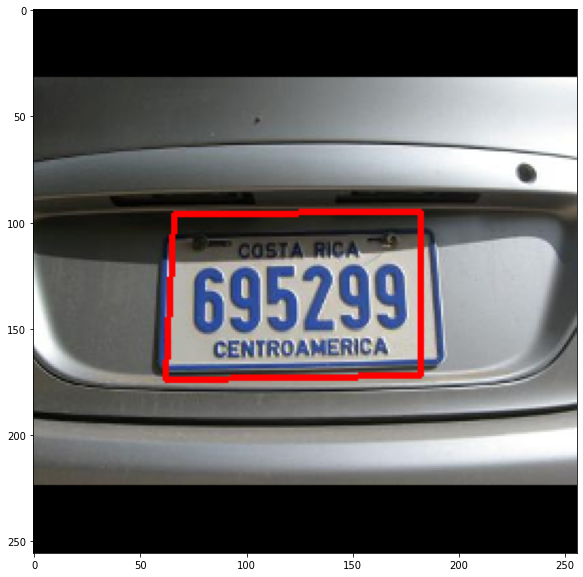

In [13]:
import matplotlib.pyplot as plt

testImgPath = '/content/obj/Cars158_png.rf.d7c2d24f9865aa932b4910a295f93149.jpg'
size = 256
img = cv2.imread(testImgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = letterbox_image(img, tuple((size,size)))
img = resized.reshape(1,size,size,3)
pred = model.predict(img)

prediction = np.squeeze(pred)
image = cv2.imread(testImgPath)
pts = np.array([[prediction[0], prediction[1]], [prediction[2], prediction[3]], 
                [prediction[4], prediction[5]], [prediction[6], prediction[7]]],
               np.int32)

pts = pts.reshape((-1, 1, 2))
color = (255, 0, 0)
  
thickness = 2

image = cv2.polylines(np.array(resized), [pts], 
                      True, color, thickness)
plt.figure(figsize = (10,10))
plt.imshow(image)